<a href="https://colab.research.google.com/github/mayank28082003/Course-Management-System/blob/main/Speech_to_Emotion_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#downloading required datasets from kaggle
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ejlok1/cremad
! kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio
! kaggle datasets download -d "ejlok1/surrey-audiovisual-expressed-emotion-savee"
! kaggle datasets download -d "ejlok1/toronto-emotional-speech-set-tess"
! unzip cremad.zip
! unzip ravdess-emotional-speech-audio.zip
! unzip surrey-audiovisual-expressed-emotion-savee.zip
! unzip toronto-emotional-speech-set-tess.zip

Streaming output truncated to the last 5000 lines.
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bath_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bean_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_beg_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bite_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bone_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_book_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bought_angry.wav  
  inflating: TESS Toronto emotional 

In [ ]:
# Paths for data.
Ravdess = "/content/audio_speech_actors_01-24"
Crema = "/content/AudioWAV/"
Savee = "/content/ALL"

In [ ]:
# importing all the required libraries
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
import tensorflow
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)



In [ ]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess +'/'+dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess +'/'+ dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotions,Path
0,sad,/content/audio_speech_actors_01-24/Actor_10/03...
1,happy,/content/audio_speech_actors_01-24/Actor_10/03...
2,surprise,/content/audio_speech_actors_01-24/Actor_10/03...
3,sad,/content/audio_speech_actors_01-24/Actor_10/03...
4,calm,/content/audio_speech_actors_01-24/Actor_10/03...


In [ ]:
ravdess_directory_list

['Actor_10',
 'Actor_16',
 'Actor_20',
 'Actor_18',
 'Actor_15',
 'Actor_21',
 'Actor_07',
 'Actor_17',
 'Actor_13',
 'Actor_03',
 'Actor_01',
 'Actor_23',
 'Actor_14',
 'Actor_24',
 'Actor_09',
 'Actor_02',
 'Actor_08',
 'Actor_22',
 'Actor_19',
 'Actor_06',
 'Actor_04',
 'Actor_11',
 'Actor_05',
 'Actor_12']

In [ ]:
actor


['03-01-06-01-01-01-12.wav',
 '03-01-08-02-01-01-12.wav',
 '03-01-04-01-01-02-12.wav',
 '03-01-05-02-01-02-12.wav',
 '03-01-08-01-02-01-12.wav',
 '03-01-02-01-02-01-12.wav',
 '03-01-03-01-02-02-12.wav',
 '03-01-06-02-01-02-12.wav',
 '03-01-06-02-01-01-12.wav',
 '03-01-05-01-02-01-12.wav',
 '03-01-08-02-01-02-12.wav',
 '03-01-01-01-01-02-12.wav',
 '03-01-05-02-01-01-12.wav',
 '03-01-08-01-01-01-12.wav',
 '03-01-04-02-02-01-12.wav',
 '03-01-01-01-01-01-12.wav',
 '03-01-03-01-01-01-12.wav',
 '03-01-04-01-02-01-12.wav',
 '03-01-07-02-02-02-12.wav',
 '03-01-01-01-02-01-12.wav',
 '03-01-06-01-02-02-12.wav',
 '03-01-07-02-01-01-12.wav',
 '03-01-05-01-02-02-12.wav',
 '03-01-07-02-02-01-12.wav',
 '03-01-02-02-02-02-12.wav',
 '03-01-04-01-01-01-12.wav',
 '03-01-04-02-02-02-12.wav',
 '03-01-06-01-02-01-12.wav',
 '03-01-02-01-02-02-12.wav',
 '03-01-03-02-01-01-12.wav',
 '03-01-01-01-02-02-12.wav',
 '03-01-07-01-02-02-12.wav',
 '03-01-08-01-02-02-12.wav',
 '03-01-04-01-02-02-12.wav',
 '03-01-02-02-

In [ ]:
os.listdir(Ravdess)

['Actor_10',
 'Actor_16',
 'Actor_20',
 'Actor_18',
 'Actor_15',
 'Actor_21',
 'Actor_07',
 'Actor_17',
 'Actor_13',
 'Actor_03',
 'Actor_01',
 'Actor_23',
 'Actor_14',
 'Actor_24',
 'Actor_09',
 'Actor_02',
 'Actor_08',
 'Actor_22',
 'Actor_19',
 'Actor_06',
 'Actor_04',
 'Actor_11',
 'Actor_05',
 'Actor_12']

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema +  file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,fear,/content/AudioWAV/1014_IOM_FEA_XX.wav
1,disgust,/content/AudioWAV/1070_IEO_DIS_LO.wav
2,sad,/content/AudioWAV/1054_IWW_SAD_XX.wav
3,fear,/content/AudioWAV/1046_IWW_FEA_XX.wav
4,angry,/content/AudioWAV/1025_TSI_ANG_XX.wav


"tess_directory_list = os.listdir(Tess)\n\nfile_emotion = []\nfile_path = []\n\nfor dir in tess_directory_list:\n    directories = os.listdir(Tess +'/' +dir)\n    for file in directories:\n        part = file.\n        if part=='ps':\n            file_emotion.append('surprise')\n        else:\n            file_emotion.append(part)\n        file_path.append(Tess + dir + '/' + file)\n        \n# dataframe for emotion of files\nemotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])\n\n# dataframe for path of files.\npath_df = pd.DataFrame(file_path, columns=['Path'])\nTess_df = pd.concat([emotion_df, path_df], axis=1)\nTess_df.head()"

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee +'/'+ file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,disgust,/content/ALL/KL_d08.wav
1,sad,/content/ALL/KL_sa03.wav
2,surprise,/content/ALL/JE_su05.wav
3,surprise,/content/ALL/JK_su08.wav
4,surprise,/content/ALL/KL_su09.wav


In [ ]:
# creating Dataframe using all the 3 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_1=data_path[0:1000]
data_2=data_path[1000:2000]
data_3=data_path[2000:3000]
data_4=data_path[3000:4000]
data_5=data_path[4000:5000]
data_6=data_path[5000:6000]
data_7=data_path[6000:7000]
data_8=data_path[7000:8000]
data_9=data_path[8000:9000]
data_10=data_path[9000:-1]
data_1.shape

(1000, 2)

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

NameError: ignored

In [ ]:
path_df


,Path
0,/content/ALL/DC_d15.wav
1,/content/ALL/JK_a03.wav
2,/content/ALL/DC_sa15.wav
3,/content/ALL/DC_a05.wav
4,/content/ALL/JK_h14.wav
...,...
475,/content/ALL/JK_d02.wav
476,/content/ALL/JK_a13.wav
477,/content/ALL/DC_su15.wav
478,/content/ALL/JK_f02.wav


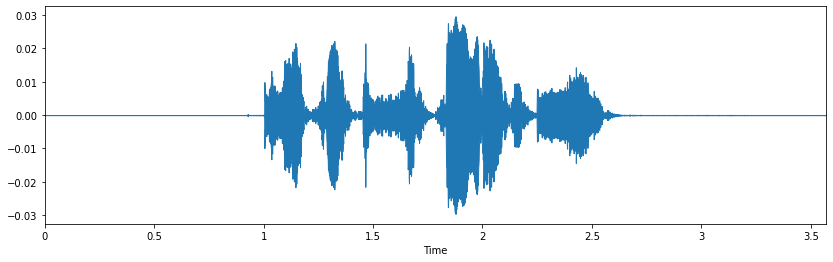

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

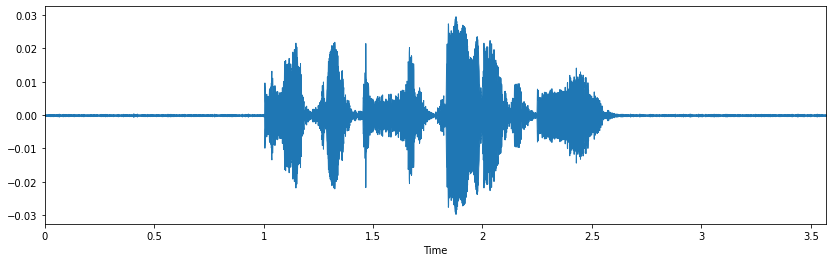

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

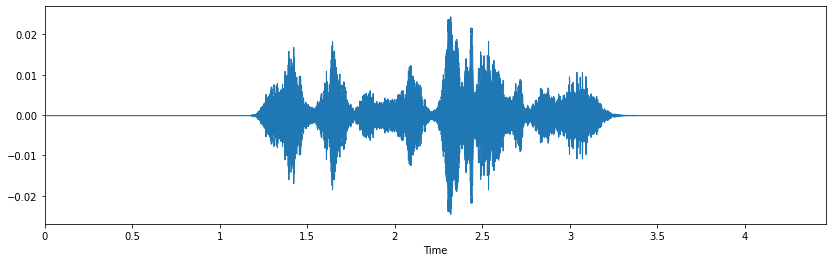

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

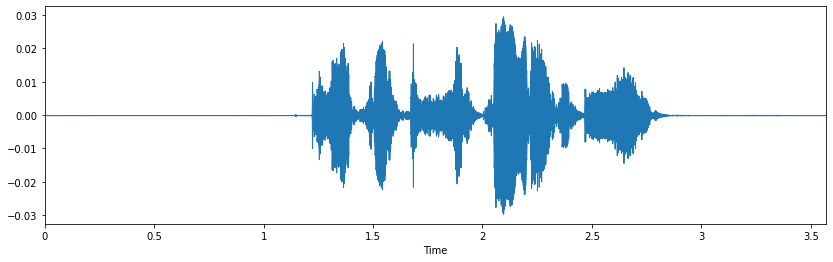

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

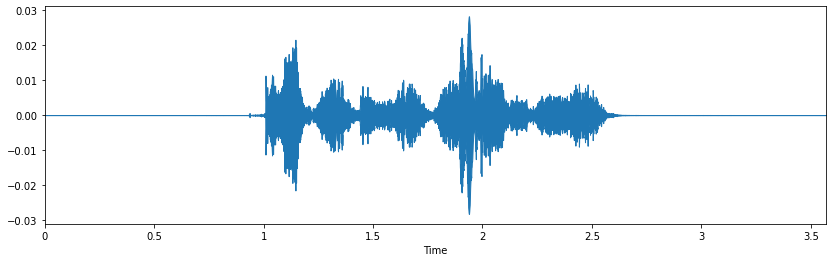

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

In [ ]:
"ref link=https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225"
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X_1, Y_1 = [], []
for path, emotion in zip(data_1.Path, data_1.Emotions):
    feature = get_features(path)

    for ele in feature:
       X_1.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
       Y_1.append(emotion)

In [ ]:
X_2, Y_2 = [], []
for path, emotion in zip(data_2.Path, data_2.Emotions):
    feature = get_features(path)

    for ele in feature:
       X_2.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
       Y_2.append(emotion)

/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [ ]:
X_3, Y_3 = [], []
for path, emotion in zip(data_3.Path, data_3.Emotions):
    feature = get_features(path)

    for ele in feature:
       X_3.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
       Y_3.append(emotion)

In [ ]:
X_4, Y_4 = [], []
for path, emotion in zip(data_4.Path, data_4.Emotions):
    feature = get_features(path)
    for ele in feature:
       X_4.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
       Y_4.append(emotion)

In [ ]:
X_5, Y_5 = [], []
for path, emotion in zip(data_5.Path, data_5.Emotions):
    feature = get_features(path)

    for ele in feature:
       X_5.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
       Y_5.append(emotion)

In [ ]:
X_6, Y_6 = [], []
for path, emotion in zip(data_6.Path, data_6.Emotions):
    feature = get_features(path)

    for ele in feature:
       X_6.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
       Y_6.append(emotion)

In [ ]:
X_7, Y_7 = [], []
for path, emotion in zip(data_7.Path, data_7.Emotions):
    feature = get_features(path)

    for ele in feature:
       X_7.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
       Y_7.append(emotion)

In [ ]:
X_8, Y_8 = [], []
for path, emotion in zip(data_8.Path, data_8.Emotions):
    feature = get_features(path)

    for ele in feature:
       X_8.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
       Y_8.append(emotion)

In [ ]:
X_9, Y_9 = [], []
for path, emotion in zip(data_9.Path, data_9.Emotions):
    feature = get_features(path)

    for ele in feature:
       X_9.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
       Y_9.append(emotion)

In [ ]:
X_10, Y_10 = [], []
for path, emotion in zip(data_10.Path, data_10.Emotions):
    feature = gt_features(path)

    for ele in feature:
       X_10.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
       Y_10.append(emotion)

In [ ]:
X=[X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10]
X=list(np.concatenate(X))
Y=[Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7,Y_8,Y_9,Y_10]
Y=list(np.concatenate(Y))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

ValueError: ignored

In [ ]:
Features=pd.read_csv('Book1.csv',)
X = Features.iloc[: ,:-1]
Y = Features['labels']

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
scaler = StandardScaler()

In [ ]:
x_left, x_test, y_left, y_test = train_test_split(X, Y, random_state=0,test_size=0.001, shuffle=True)
x_train,x_val,y_train,y_val= train_test_split(x_left,y_left, random_state=0,test_size=0.3, shuffle=True)
x_train=scaler.fit_transform(x_train)
x_val= scaler.transform(x_val)
x_test = scaler.transform(x_test)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_val= np.expand_dims(x_val,axis=2)

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

In [ ]:
x_train.shape()

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks=[rlrp])

Epoch 1/50
284/284 [==============================] - 190s 667ms/step - loss: 1.6944 - accuracy: 0.3075 - val_loss: 1.6253 - val_accuracy: 0.3325 - lr: 0.0010
Epoch 2/50
284/284 [==============================] - 121s 427ms/step - loss: 1.6275 - accuracy: 0.3344 - val_loss: 1.5749 - val_accuracy: 0.3613 - lr: 0.0010
Epoch 3/50
284/284 [==============================] - 120s 421ms/step - loss: 1.5791 - accuracy: 0.3516 - val_loss: 1.5434 - val_accuracy: 0.3723 - lr: 0.0010
Epoch 4/50
284/284 [==============================] - 120s 422ms/step - loss: 1.5556 - accuracy: 0.3606 - val_loss: 1.5046 - val_accuracy: 0.3712 - lr: 0.0010
Epoch 5/50
284/284 [==============================] - 121s 427ms/step - loss: 1.5329 - accuracy: 0.3697 - val_loss: 1.4885 - val_accuracy: 0.3873 - lr: 0.0010
Epoch 6/50
284/284 [==============================] - 119s 418ms/step - loss: 1.5032 - accuracy: 0.3855 - val_loss: 1.4879 - val_accuracy: 0.3816 - lr: 0.0010
Epoch 7/50
284/284 [==========================

In [ ]:
model.save('ds3_model')

print("Accuracy of our model on validation data : " , model.evaluate(x_val,y_val)[1]*100 , "%")
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

NameError: ignored

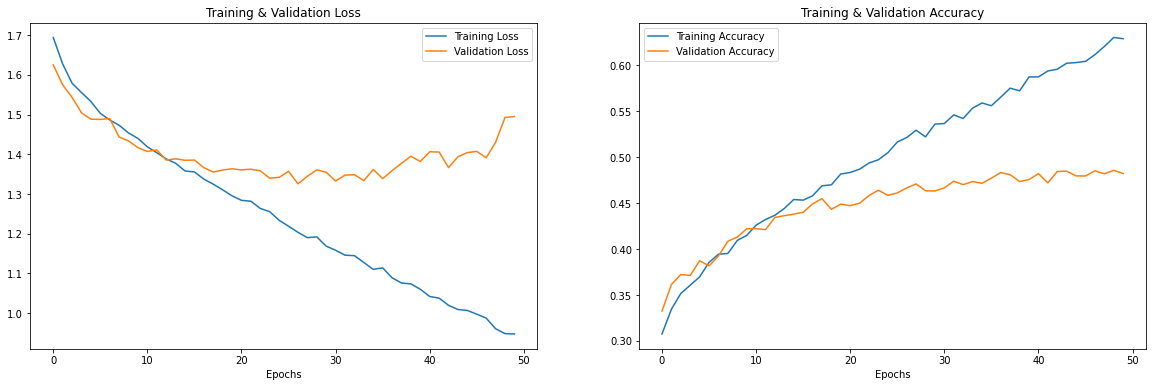

In [ ]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , val_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , val_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)


In [ ]:

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = np.unique(y_test) , columns =  np.unique(y_test))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
!zip -r /content/ds3_model.zip /content/ds3_model

In [ ]:
!unzip ds3_model.zip


Archive:  ds3_model.zip
replace content/ds3_model/saved_model.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: content/ds3_model/saved_model.pb  
  inflating: content/ds3_model/variables/variables.index  
  inflating: content/ds3_model/variables/variables.data-00000-of-00001  
  inflating: content/ds3_model/keras_metadata.pb  


2022-12-04 09:44:34.232 Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 4 of 4). These functions will not be directly callable after loading.
INFO:tensorflow:Assets written to: ram://2083442a-66ed-4357-930b-1be070112ac2/assets
2022-12-04 09:44:34.572 Assets written to: ram://2083442a-66ed-4357-930b-1be070112ac2/assets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!./ngrok authtokens 2IRomKQ1P7aFzBkwZe1f3K5hnD7_4cSXrs2oNL2aNeU4FEcXz

/bin/bash: ./ngrok: No such file or directory


In [ ]:
pd.DataFrame(Y)

,0,1,2,3,4,5,6,7
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
94,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
95,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyngrok import ngrok
public_url = ngrok.connect(port='8501')
public_url

PyngrokNgrokHTTPError: ignored

In [ ]:
model=keras.models.load_model("/content/content/ds3_model")
import pickle
pickle_out=open("classifier.pkl","wb")
pickle.dump(model,pickle_out)
pickle_out.close()

In [ ]:
%%writefile streamlit_app.py
import streamlit as st
import pickle
from audio_recorder_streamlit import audio_recorder
from sklearn.preprocessing import OneHotEncoder
arr=['anger', 'calm','disgust', 'fear','happy', 'neutral', 'sad', 'surprise']
import numpy as np
import librosa
pickle_in=open("classifier.pkl","rb")
classifier=pickle.load(pickle_in)
def prediction(feature):
    prediction=classifier.predict(feature)
    print(prediction)
    return prediction

def extract_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

encoder=OneHotEncoder()
arr=encoder.fit_transform(np.array(arr).reshape(-1,1)).toarray()

def main():
  audio = audio_recorder()
  if audio:
      st.audio(audio, format="audio/wav")
      wav_file = open("ds3_audio.wav", "wb")
      wav_file.write(audio)
      path="/content/ds3_audio.wav"
      feature=extract_features(path)
      feature=feature.reshape(1,-1)
  res=""
  if st.button("Predict"):
     res=prediction(feature)
     res=encoder.inverse_transform(res)

  st.success("The label is {}".format(res))

if __name__=='__main__':
  main()


Overwriting streamlit_app.py


In [ ]:
!pip install audio-recorder-streamlit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 5.2 MB/s 
     |████████████████████████████████| 9.2 MB 70.0 MB/s 
     |████████████████████████████████| 4.7 MB 34.6 MB/s 
     |████████████████████████████████| 182 kB 62.4 MB/s 
     |████████████████████████████████| 237 kB 57.3 MB/s 
     |████████████████████████████████| 164 kB 65.1 MB/s 
     |████████████████████████████████| 78 kB 6.9 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 51 kB 6.5 MB/s 
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=e556da86090cd55ebf395bce542aa2ab61ba0483fb94a49b7a0523678ecc5b13
  Stored in directory: /root/.cache/pip/wheels/19/09/72/3eb74d236bb48bd0f3c6c3c83e4e0c5bbfcbcad7c6c3539db8
Successfully built validators


In [ ]:
!streamlit run /content/streamlit_app.py & npx localtunnel --port 8501

/bin/bash: streamlit: command not found
npx: installed 22 in 5.781s
your url is: https://few-roses-see-35-239-28-148.loca.lt
^C


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


NameError: ignored